In [4]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

from fastai.vision.all import *

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [19]:
class ConVAE(nn.Module):
    def __init__(self):
        super(ConVAE,self).__init__()

        self.encoder = nn.Sequential(                                       #28
                nn.Conv2d(1, 32, kernel_size= 3, stride= 2, padding  = 1),  #14
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding  = 1),  #7
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Flatten(),
                nn.Linear(3136, 64),
                nn.ReLU()
        )

        self.decoder = nn.Sequential(                                       
                nn.Linear(2, 64),
                nn.ReLU(),
                nn.Linear(64, 3136),
                nn.ReLU(),
                nn.Unflatten(1, (64, 7, 7)),    #7
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride= 2, padding  = 1, output_padding=1),   #14
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=3, stride= 2, padding  = 1, output_padding=1),  #28
                nn.Sigmoid()
        )

        self.fc1_mu = nn.Linear(64, 2)
        self.fc2_logvar = nn.Linear(64, 2)


    def encode(self, x):
        h = self.encoder(x)
        return self.fc1_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [29]:
model = ConVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
num_epochs = 12

In [31]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(dataloader):
        # Forward pass
        # x = x.to(device).view(-1, 784)
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if (i+1) % 200 == 0:
        #     print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
        #            .format(epoch+1, num_epochs, i+1, len(dataloader), reconst_loss.item(), kl_div.item()))
    print ("Epoch[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, reconst_loss.item(), kl_div.item()))


Epoch[1/12], Reconst Loss: -443184.0625, KL Div: 804.7179
Epoch[2/12], Reconst Loss: -483284.4688, KL Div: 1150.5583
Epoch[3/12], Reconst Loss: -550444.9375, KL Div: 1166.3635
Epoch[4/12], Reconst Loss: -578554.8750, KL Div: 1200.4619
Epoch[5/12], Reconst Loss: -602509.2500, KL Div: 1607.5229
Epoch[6/12], Reconst Loss: -648645.3750, KL Div: 1744.1052
Epoch[7/12], Reconst Loss: -638629.2500, KL Div: 2267.7778
Epoch[8/12], Reconst Loss: -684661.9375, KL Div: 1518.8853
Epoch[9/12], Reconst Loss: -659199.8750, KL Div: 1861.1409
Epoch[10/12], Reconst Loss: -699509.0000, KL Div: 1421.9807
Epoch[11/12], Reconst Loss: -699026.8750, KL Div: 1745.7147
Epoch[12/12], Reconst Loss: -708290.6250, KL Div: 1704.9421


In [32]:
with torch.no_grad():
    z = torch.randn(32, 2).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)

    out2, _, _ = model(x)
    out2 = out2.view(-1, 1, 28, 28)

    out3 = x.view(-1, 1, 28, 28)

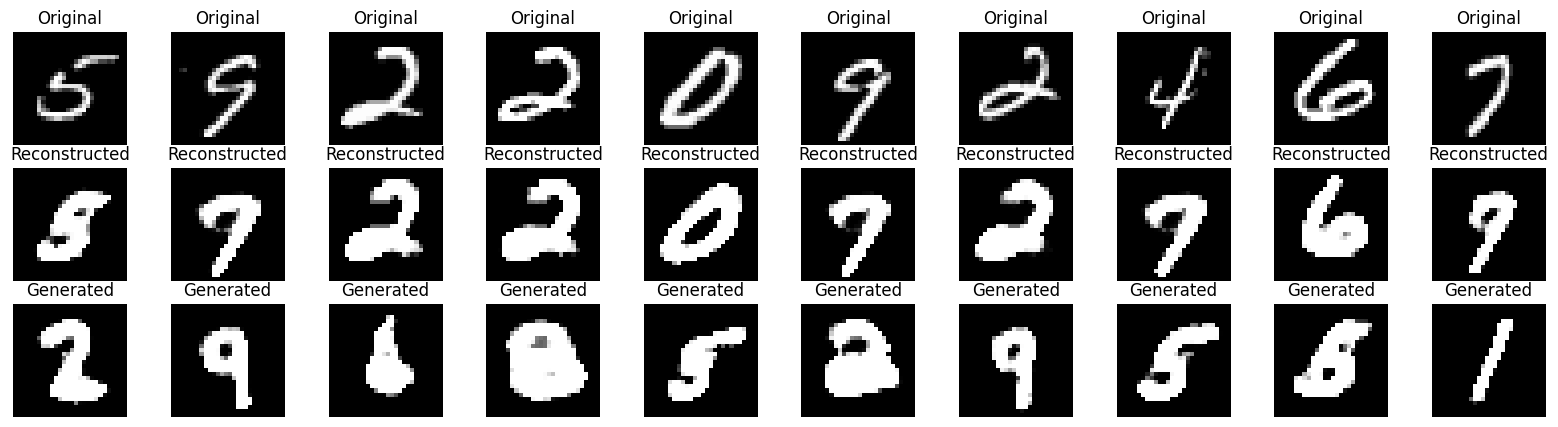

In [33]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 5))
for i in range(num_images):

    # inputs
    axes[0, i].imshow(out3[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # outputs
    axes[1, i].imshow(out2[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

    # rand sample
    axes[2, i].imshow(out[i].squeeze().cpu().numpy(), cmap='gray')
    axes[2, i].set_title('Generated')
    axes[2, i].axis('off')